In [1]:
bayesplay::loadpackages()

# Basic intro to Markov chain Monte Carlo (MCMC) methods

In our examples up until now I've deliberately simplified things by focusing on inferences about a **single** parameter—either the mean or the effect size. But the data we deal with usually needs multiple parameters to adequately describe it. 

Let's take a simple example: If we sample some data from a population that has a mean of $\mu$ and a variance of $\sigma^2$ then our data can be described by two parameters — $\mu$ and $\sigma$. We can estimate the values of these parameters, given our data. The most likely values for these parameters correspond to mean and the sd. However, these are only the **most likely** values. If we go back and look at our likelihood functions from before, we'll see that our likelihood functions had a peak, but they as had a spread. That is, although we had the most likely estimate, there was some uncertainty associated with it. 

Instead of just using the analytic formulas to get the most likely values of the parameters let's try a different approach based on the idea of the likelihood. The likelihood function tells us how likely the parameters are given the data, but up until now we've only had a likelihood function with one parameter that can vary—for our normal likelihoods, this was the mean. But we can just add in a second parameter, so now our likelihood function will look like this: 

$$\mathcal{L}(\mathbf{y}|\mu,\sigma)$$ 

We're going to extend this idea to include multiple events (multiple data points). The likelihood of multiple independent events is just the product of the likelihoods of the individual events. So for example, if $\mathbf{y}$ was made up of multiple data points $\{x_1,x_2,...,x_n\}$ then our new formula would look something like this:

$$\prod_{i=1}^n\mathcal{L}(x_i|\mu,\sigma)$$

To find the most likely values of $\mu$ and $\sigma$, given our data, we just find the values of $\mu$ and $\sigma$ that maximise the value of the equation above. The simple way to do this is to just try a bunch of values. 

Let's generate some data (with a known $\mu$ and $\sigma$) and then try and recover these values. We'll just try a bunch of values for $\mu$ and $\sigma$ and see which values maximise our likelihood function.

The parameters we're putting in are $\mu$ = 10 and $\sigma$ = 5

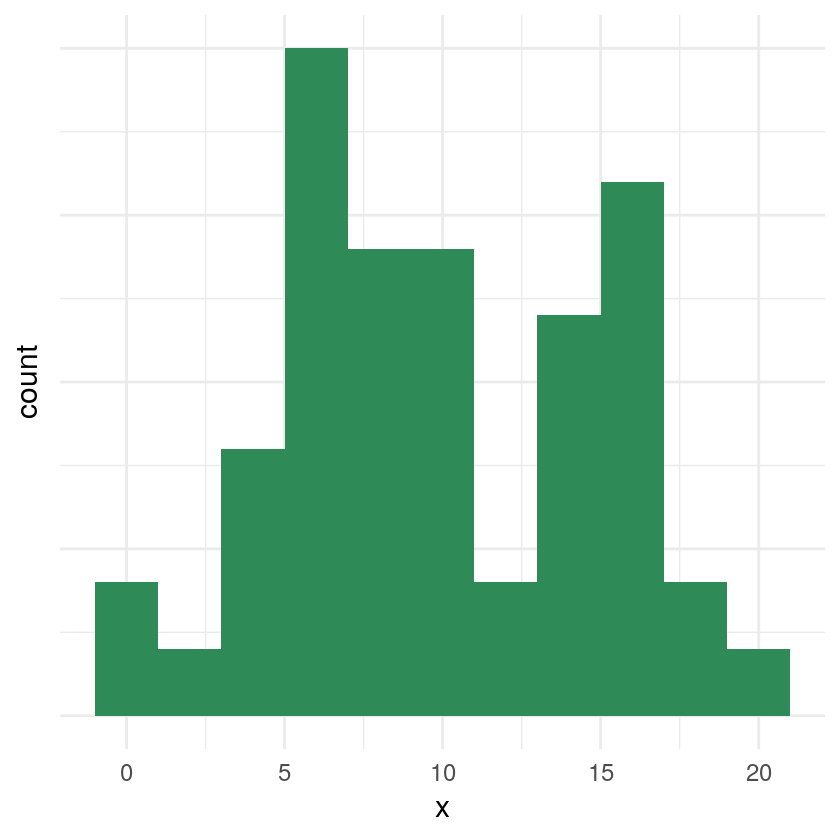

In [13]:
# 1
# lets generate some data specific characteristics
set.seed(5)
mu = 10
sigma = 5

# we'll generate N data point
N = 50

sample_data = as.numeric(mu + sigma * scale(rnorm(n = N, 0, 1)))

ggplot() + geom_histogram(mapping = aes(x = sample_data),binwidth = 2, fill = "seagreen") + 
scale_y_continuous(name = "count", labels = NULL) + 
scale_x_continuous(name = "x") + theme_minimal(18) 

glue::glue("The parameters we're putting in are $\\mu$ = {mu} and $\\sigma$ = {sigma}") %>%
IRdisplay::display_markdown()

In [14]:
# 2 


grid_points = 10000


# lets try estimate the mean and sd

mean_opts = seq(9.8,10.1, length.out =  grid_points / 1000) # some values for the mean to try out
sd_opts = seq(4.7, 5.1, length.out =  grid_points) # some values for the sd to try out

opts = cross_df(list(mean = mean_opts, 
              sd = sd_opts)) %>% set_names(c("m","s")) # make every possible combination of our two vectors

# write our liklihood function
norm.lik = function(D, m, s){
    
    # instead of working out the product of the likelihoods 
    # we'll just take the sum of the log values
    # because they're mathematically equivalent
    log.lik = sum(dnorm(sample_data, mean = m, sd = s, log = T))
    
    # then we just "un-log" it
    exp(log.lik)
    
}

log.likes = pmap_dbl(opts,  function(m,s) norm.lik(D = sample_data, m = m, s = s))
                                   
# find the row that contains the max likelihood
                                   
max.row = which.max(log.likes)                       

# get the mean and sd from this row
                                   
opts[max.row,] %>% 
glue::glue_data("The parameters we're getting our are $\\mu$ = {round(m,3)} and $\\sigma$ = {round(s,3)}") %>%
IRdisplay::display_markdown()

The parameters we're getting our are $\mu$ = 10 and $\sigma$ = 4.95

You'll see that we do a pretty good job of recovering the parameters. This, however, isn't the most efficient way to solve this problem. Instead, we can use the `fitdistr` function from the **MASS** package. This implements a more efficient algorithm, but returns essentially the same results.


In [15]:
# 3

# Do mle the smart way!

mle_smart_way = MASS::fitdistr(sample_data, densfun = "normal") 
glue::glue("using `fitdistr` we find $\\mu$ = {round(mle_smart_way$estimate[[1]],3)} 
and $\\sigma$ = {round(mle_smart_way$estimate[[2]],3)}") %>%
IRdisplay::display_markdown()

using `fitdistr` we find $\mu$ = 10 
and $\sigma$ = 4.95

Now we have **mle** estimates. But we don't have any idea of the variances associated with these estimates. There's a few ways to tackle this problem. We can use the approach we used above to not only get the most likely parameters values, but also to get a sense of the range of likely parameter values. This approach will work for simple problems, but not for the more complex problems we'll encounter later, so we'll try to come up with a more general approach. The more general approach is just to **sample** from the parameter space and to just draw **more samples** from parts of the parameter space that are more likely given our data. Once we've done that, we can just draw a histogram of our samples. Parameter values that are more likely will occur more often in our sample, and ones that are less likely will occur less in our sample. But how do we do that?

In our toy example below what we'll do is pick a value for our mean. Then we'll get the product of our likelihoods (we'll actually get the sum of the log likelihoods and then "un-log" it because, computationally, this will work better). Then we'll pick a new value some distance from our current value, and we'll get the product of the likelihoods for this new value. If the new value is more likely given our data, then we'll add that value to our list (with a certain probability). Else, we'll pick a new value again add repeat the process of comparing the likelihood of our new value to our current value. At the end we'll draw a histogram of all the values we added to our list, and a plot of our samplers journey through the sample space. 

The mean of our means is 9.96

The sd of our means is 0.7

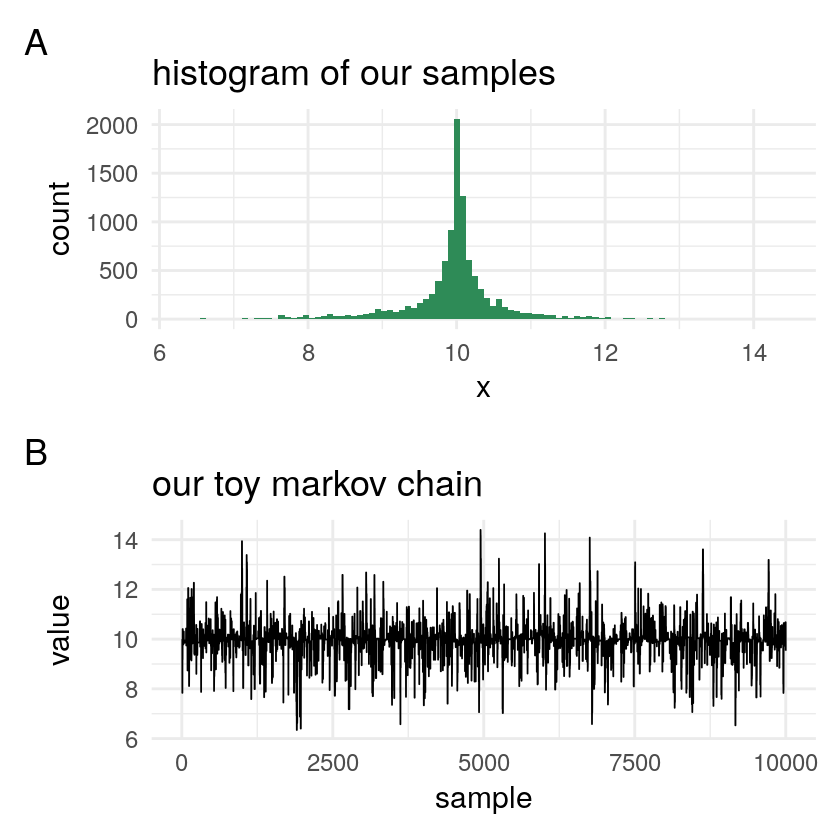

In [16]:
# 4

set.seed(3)

# a toy MCMC algorithm

mean_estimate = mean(sample_data)
starting_mu = mean_estimate
sd_fixed = sqrt(sum((sample_data - mean_estimate)^2 * 1/N))
n_samples = 10000


parameter_sample = rep(0,n_samples)
parameter_sample[1] = starting_mu

for(i in 2 : n_samples){
  
  
  
  current_mu = parameter_sample[i-1]
  
  # get the product of the likelihood for the current mu value
  current_lik = sum(dnorm(sample_data, mean = current_mu, sd = sd_fixed, log = T))
  
  
  # take step 
  new_mu = current_mu  + rnorm(n = 1,0,1)
  
  # get product of likelihood for the new mu value
  new_lik = sum(dnorm(sample_data, mean = new_mu, sd = sd_fixed, log = T))
  
  
  prop = ifelse(new_lik > current_lik,.9,.1)
  
  if((runif(1) < prop)){
    parameter_sample[i] = new_mu
  } else {
    parameter_sample[i] = current_mu
  }
  
}

glue::glue("The mean of our means is {round(mean(parameter_sample),2)}") %>% IRdisplay::display_markdown()
glue::glue("The sd of our means is {round(sd(parameter_sample),2)}") %>% IRdisplay::display_markdown()

hist = ggplot(tibble(x = parameter_sample)) + geom_histogram(aes(x = x), bins = 100, fill = "seagreen") + 
theme_minimal(18) + labs(title = "histogram of our samples")

chain = ggplot(tibble(y = parameter_sample, x = 1:n_samples)) + geom_line(aes(x = x, y = y)) + 
scale_y_continuous(name = "value") + scale_x_continuous(name = "sample") +
theme_minimal(18) + labs(title = "our toy markov chain")

hist / chain + plot_annotation(tag_levels = "A")

In the above example, how often we sample certain areas of the parameter space is **only** determined by the likelihood. But do we want to do this? We might have reasons for wanting to sample certain areas more heavily. To do this, we can just add a **prior** which will **weight** our likelihood (in fact, we already have an implicit prior, in that we're weighting each possible parameter value equally). That way, all things being equal, regions of the parameter space that are more heavily weighted will be sampled more heavily. 

Building efficient MCMC samplers, especially when we want to incorporate priors, is actually pretty difficult. So we're not going to build our own (at least not beyond the toy example above). Instead, we'll take advantage of an off-the-shelf algorithm that is more efficient than the one we can build ourselves. The exact algorithm we'll use is **Hamiltonian Monte Carlo**. If you'd like to know more about the different algorithms, and Hamiltonian Monte Carlo in particular, then [Betancourt (2018)](https://arxiv.org/abs/1701.02434) provides a comprehensive introduction

## Adding priors to our estimates

Before we start adding priors to our estimates let's first have a think about **what** the estimates are. If you remember from the module on [Bayes rule](part4.ipynb#Proportional-form), we saw the following formula:

$$p(\theta|Y) \propto{} \mathcal{L}(\theta|Y) \cdot{}p(\theta)$$
 This formula told us that the posterior distribution for a parameter is **proportional** to likelihood multiplied by a prior. What our MCMC sampler is doing is deciding which parameter values to include in our list according to the following ratio:

$$\frac{\mathcal{L}(\theta_1|Y) \cdot{}p(\theta_1)}{\mathcal{L}(\theta_2|Y) \cdot{}p(\theta_2)},$$

where $\theta_1$ and $\theta_2$ are the current and new values of the parameter. You'll notice that this is just the ratio of the two posteriors:

$$\frac{p(\theta_1|Y)}{p(\theta_2|Y)}.$$

These means that, in our list of parameter values, parameter values that have a higher posterior probability will be represented more in our list of values. That is, our list of values **will be the posterior distribution** of that parameter given the data and our prior. MCMC, therefore, allows us to directly **draw samples from the posterior**. We don't have to compute the posterior, we just draw samples from it!

Before we try drawing samples from a posterior, let's first directly compute it so that we can check whether our values match. We'll do this for a simple example so that we can use a **conjugate prior** to directly compute the posterior. Remember, we won't be able to do this for models more complex than this simple one, which is why we'll need to use MCMC methods. But this simple one will serve as an illustration. 

To keep things easy, we'll assume we **know** $\sigma$. For our prior, we'll use an **extremely** wide normal (i.e., $\sigma$ will be large) distribution which we'll centre at 0. We will discuss priors for computing posteriors in a coming section, but from the code below you'll notice that if the $\sigma$ for the prior is large, the prior will exert very little influence on the posterior.


In [17]:
# 5

# generate some data
N = 50 
mean = 10
sd = 10

sample_data = as.numeric(mean + sd * scale(rnorm(n = N, 0, 1)))

# set values for our prior
prior_mean = 0
prior_sd = 100000

# compute values for posterir
posterior_mean = (1 / (((1)/(prior_sd^2)) + ((N)/(sd^2)))) * ( ((prior_mean)/(prior_sd^2)) + ((sum(sample_data))/(sd^2)))
posterior_se = sqrt((((1/(prior_sd^2)) + (N/(sd^2))))^-1)

glue::glue("Our posterior for $\\mu$ is Normal({round(posterior_mean)}, {round(posterior_se,2)})") %>%
IRdisplay::display_markdown()


Our posterior for $\mu$ is Normal(10, 1.41)

Now that we have our computed posterior, we'll use MCMC to draw samples from it. We'll use an **R** package called **greta**. We won't be making much use of **greta** in the rest of the course; however, because it has relatively semantically transparent syntax it'll be useful for introducing MCMC. 

We'll also estimate our $\sigma$ parameter, instead of assuming it's known.  For our prior for $\sigma$ we'll use a **inverse-gamma** distribution. This is a good choice because an **inverse-gamma** distribution is only defined for values > 0, and $\sigma$ must be greater that 0. We'll include a plot so we know what it looks like.


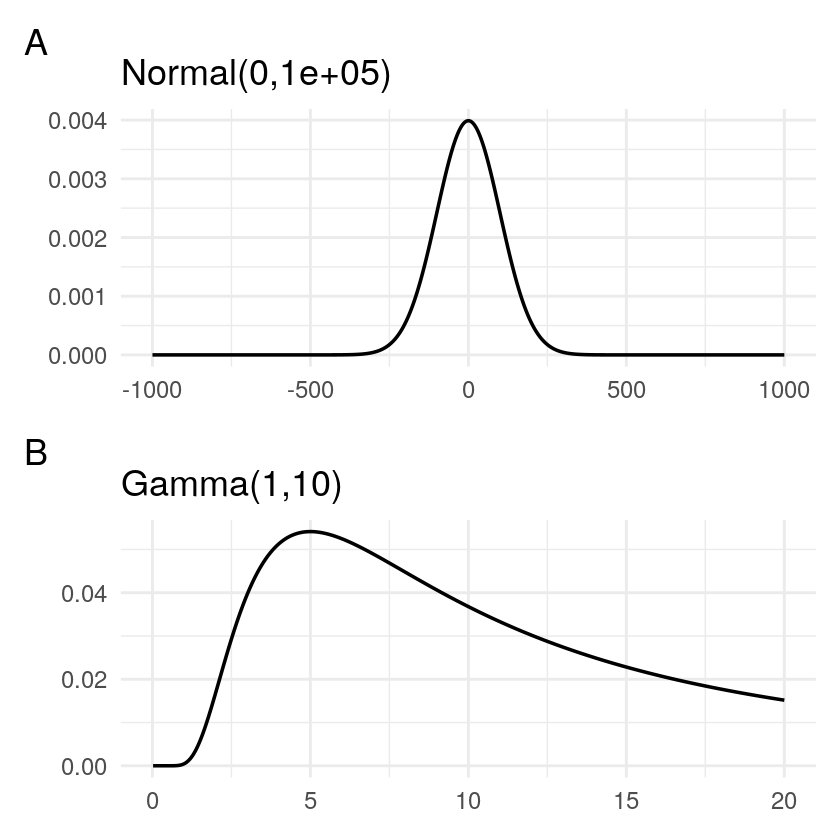

In [18]:
# 6
# specify the data
Y = greta::as_data(sample_data)

# specify the priors for μ and σ
mu = greta::normal(mean = prior_mean, sd = prior_sd)
sigma = greta::inverse_gamma(1,10)


# make some plots
sigma_prior = tibble(x = seq(0,20, length.out = 1000)) %>% 
mutate(y = invgamma::dinvgamma(x = x, 1,10)) %>% ggplot() +
geom_line(aes(x = x, y = y), na.rm = T, size = 1) + 
labs(x = NULL, y = NULL, title = "Gamma(1,10)") + theme_minimal(18)

mu_prior = tibble(x = seq(-1000,1000, length.out = 100000)) %>% 
mutate(y = dnorm(x = x, mean = 0, sd = 100)) %>% ggplot() +
geom_line(aes(x = x, y = y), na.rm = T, size = 1) + 
labs(x = NULL, y = NULL, title = glue::glue("Normal({prior_mean},{prior_sd})")) + theme_minimal(18)

mu_prior / sigma_prior  + plot_annotation(tag_levels = "A")

In [19]:
# 7

# specify the likelihood
greta::distribution(Y) = greta::normal(mu,sigma)

# initialise the model
greta_model = greta::model(mu,sigma)

# draw samples from the posterior
draws = greta::mcmc(greta_model, sampler = greta::hmc(), verbose = F, chains = 4, n_samples = 2000, n_cores = 6)

# tidy up the draws
mcmc = Reduce(function(x,y) rbind(x,y), draws) %>% as_tibble()

Let us also take a look at the MCMC chains.

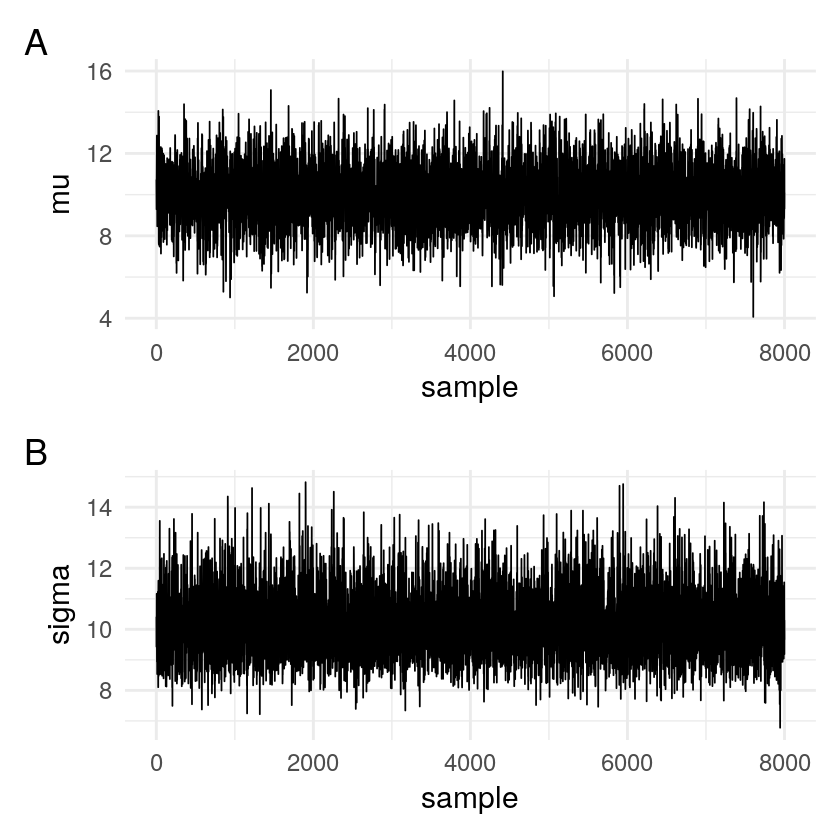

In [20]:
mu_chain = mcmc %>% ggplot(aes(x = 1:dim(mcmc)[1], y = mu)) + geom_line() + theme_minimal(18) + 
labs(x = "sample")

sigma_chain = mcmc %>% ggplot(aes(x = 1:dim(mcmc)[1], y = sigma)) + geom_line() + theme_minimal(18) + 
labs(x = "sample")

mu_chain / sigma_chain + plot_annotation(tag_levels = "A")

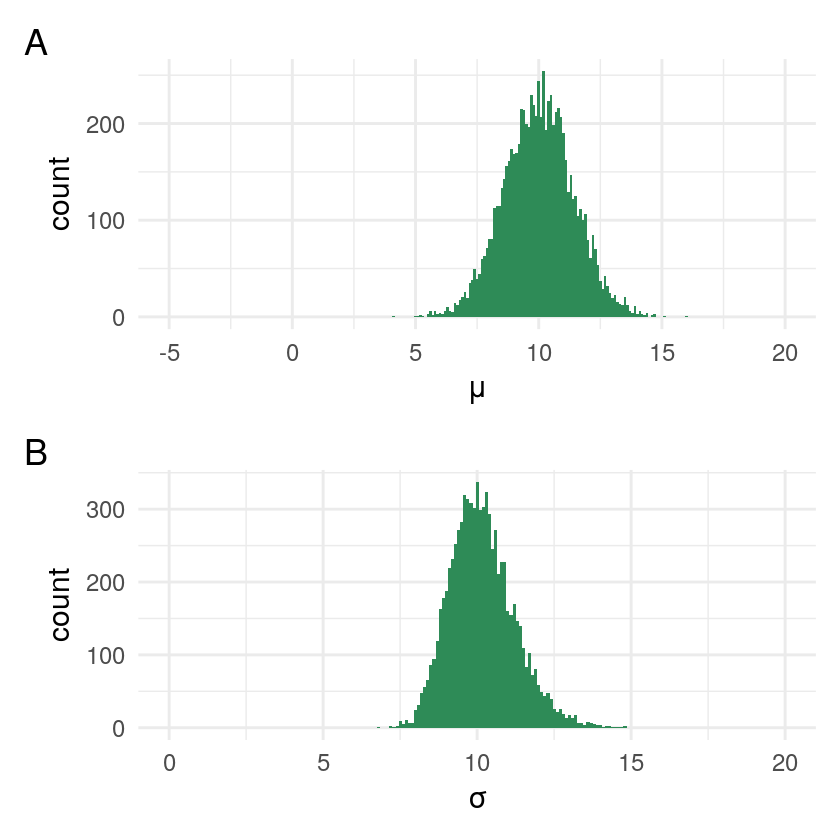

In [21]:
# 9

# draw histograms of the two posteriors

mu_plot = ggplot(mcmc) + geom_histogram(aes(x = mu), fill = "seagreen", binwidth = .1, na.rm = T) + 
scale_x_continuous(name = "μ", limits = c(-5,20)) + theme_minimal(18)

sigma_plot = ggplot(mcmc) + geom_histogram(aes(x = sigma), fill = "seagreen", binwidth = .1, na.rm = T) + 
scale_x_continuous(name = "σ", limits = c(0,20)) + theme_minimal(18)

mu_plot / sigma_plot + plot_annotation(tag_levels = "A")


In [22]:
# 10

# make a summary table with the mode and 95 percentile interval
rbind(tidybayes::mean_qi(mcmc$mu, .width = .95),
      tidybayes::mean_qi(mcmc$sigma, .width = .95)) %>%
add_column(parameter = c("$\\mu$","$\\sigma$"),`.before` = 1) %>% select(1:4)%>%
set_colnames(c("parameter","mean","lower","upper")) %>% 
knitr::kable(format = "html", digits = 2, caption = "Posterior from MCMC estimation") %>% 
kableExtra::kable_styling(full_width = F) %>%
as.character() %>% IRdisplay::display_html()


parameter,mean,lower,upper
$\mu$,10.01,7.23,12.81
$\sigma$,10.16,8.35,12.47


In [23]:
# 11

tibble(parameter = c("$\\mu$","$\\sigma$"), 
      mean = c(round(posterior_mean,2),"not computed"),
      lower = c(round(posterior_mean - (qnorm(.975) * posterior_se),2), "not computed"),
      upper = c(round(posterior_mean + (qnorm(.975) * posterior_se),2), "not computed"))  %>% 
knitr::kable(format = "html", digits = 2, caption = "Analytically calculated posterior") %>% 
kableExtra::kable_styling(full_width = F) %>%
as.character() %>% IRdisplay::display_html()

parameter,mean,lower,upper
$\mu$,10,7.23,12.77
$\sigma$,not computed,not computed,not computed


We can see that the values are essentially identical. 